# Practical 2 - Mapping with cartopy

In the first practical for EGM711, you learned how to use ArcGIS Pro to make maps, given shapefiles of different features of interest in Northern Ireland. In this practical, you will repeat the exercise, this time using `cartopy`, `geopandas`, and `matplotlib`, three python packages used for making maps, working with vector data, and making plots, respectively. 

## Objectives
- become familiar with geopandas, cartopy, and matplotlib, including reading the provided documentation
- use list comprehensions to simplify some for loops

## 1. Getting started
First, run the cell below. It will load the python modules we'll be using in the practical, as well as define a few helper functions that we'll use later on. For now, don't worry too much about what each individual line does - we'll go over these in a bit more depth as we go. Remember also that if you get stuck, you can get help in a few ways:

1. the built-in help (i.e., `help(plt.text)`)
2. using ipython's (the python interpreter used by jupyter-notebooks) help shortcut (i.e., `plt.text?`)
3. finding the online documentation for the module (usually achieved via option 4)
4. searching google (or your search engine of choice)
5. consulting your favorite medicine man/shaman/spiritual guide
6. asking the instructor, who will in all likelihood resort to one of the other options (usually 5 or 4).

In [1]:
# this lets us use the figures interactively
%matplotlib inline

import os
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.ion() # make the plotting interactive

# generate matplotlib handles to create a legend of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.5, 0.95)):
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=9, transform=ax.projection)
    ax.plot([sbx, sbx - 5000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-5000, sbx -10000], [sby, sby], color='w', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-4500, '10 km', transform=ax.projection, fontsize=8)
    ax.text(sbx-12500, sby-4500, '5 km', transform=ax.projection, fontsize=8)
    ax.text(sbx-24500, sby-4500, '1 km', transform=ax.projection, fontsize=8)

# load the outline of Northern Ireland for a backdrop
outline = gpd.read_file(os.path.abspath('data_files/NI_outline.shp'))

## 2. Loading the data
Great. Now that we've imported most of the modules we'll be needing, and defined a few helper functions, we can actually load our data. To load the shapefile data, we will use [GeoPandas](http://geopandas.org/), an open-source package designed to make working with geospatial data in python easier. 

GeoPandas is built off of Pandas, a powerful data analysis tool. We will be working with both of these packages more in the weeks to come.

To open a shapefile, we use the `gpd.read_file()` ([documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html)) method:

In [2]:
towns = gpd.read_file(os.path.abspath('data_files/Towns.shp'))
water = gpd.read_file(os.path.abspath('data_files/Water.shp'))
rivers = gpd.read_file(os.path.abspath('data_files/Rivers.shp'))
counties = gpd.read_file(os.path.abspath('data_files/Counties.shp'))

GeoPandas loads the data associated with a shapefile into a GeoDataFrame, a tabular data structure that always has a column describing a feature's geometry. Each line in the table corresponds to a feature in the shapefile, just like the attribute table you are familiar with from ArcGIS/QGIS.

To see a subset of a GeoDataFrame, we can use the ``head()`` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)) method:

In [32]:
towns.head(10)

,TOWN_NAME,X_COORD,Y_COORD,STATUS,town_city,geometry
0,Strabane,234500,397700,Town,0,POINT (598678.141 6076502.428)
1,Antrim,315300,387000,Town,0,POINT (679600.889 6066957.917)
2,Armagh,287600,345500,City,1,POINT (652499.689 6025077.688)
3,Ballymena,310700,403400,Town,0,POINT (674768.456 6083287.267)
4,Banbridge,312700,346200,Town,0,POINT (677581.614 6026133.379)
5,Bangor,350500,381600,Town,0,POINT (714868.090 6062060.790)
6,Carrickfergus,341300,387400,Town,0,POINT (705587.817 6067728.251)
7,Coleraine,284700,432400,Town,0,POINT (648362.631 6111905.939)
8,Downpatrick,348700,344600,Town,0,POINT (713594.372 6025044.369)
9,Enniskillen,224000,344000,Town,0,POINT (588946.088 6022676.747)


To select rows in the dataframe using an index, we can use ``.loc`` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)):

In [4]:
water.loc[0] # should show the row for Lough Neagh

OBJECTID                                                    426
localId                                           UKGBNI3NB0032
namespace                                           Lough Neagh
spZoneType                                        lakeWaterBody
Area_km2                                              381.26885
Shape_STAr                                        381268852.195
Shape_STLe                                         229598.41621
geometry      POLYGON ((661992.3586612788 6070007.115231799,...
Name: 0, dtype: object

Note that ``.loc`` is not a method, since we use square brackets:`[` and `]`, instead of round brackets/parentheses. Instead, it's a way to index or slice a GeoDataFrame.

This means that we can also use ``.loc`` with conditional statements. For example, if we wanted to select all bodies of water that are smaller than 1 square kilometer, we could use something like this:

In [5]:
water.loc[water['Area_km2'] < 1]

,OBJECTID,localId,namespace,spZoneType,Area_km2,Shape_STAr,Shape_STLe,geometry
1,427,UKGBNI3NB0018,Lough Gullion,lakeWaterBody,0.87955,879545.755661,4566.067559,"POLYGON ((665002.637 6041789.851, 665006.784 6..."
2,428,UKGBNI3NB0034,Stonyford Reservoir,lakeWaterBody,0.55215,552149.025482,3362.846807,"POLYGON ((686555.115 6050084.548, 686556.671 6..."
4,430,UKGBNI3NW0036,Castlehume Lough,lakeWaterBody,0.60717,607174.288490,5483.032678,"POLYGON ((584206.326 6029497.087, 584208.879 6..."
5,431,UKGBNI3NE0028,Lough Mourne,lakeWaterBody,0.50854,508536.425438,3822.843162,"POLYGON ((705127.610 6073767.014, 705131.912 6..."
7,433,UKGBNI3NB0026,Spelga Dam,lakeWaterBody,0.62042,620416.085281,4299.846208,"POLYGON ((691960.585 6007404.918, 691969.517 6..."
8,434,UKGBNI3NB0027,Lough Fea,lakeWaterBody,0.62423,624230.017395,4468.608674,"POLYGON ((639849.273 6067005.639, 639849.620 6..."
10,436,UKGBNI3NE0023,Clea Lakes,lakeWaterBody,0.65294,652941.158401,11785.580844,"POLYGON ((715606.469 6036324.239, 715601.749 6..."
11,438,UKGBNI3NE0019,Silent Valley Reservoir,lakeWaterBody,0.94689,946894.198784,7411.632700,"POLYGON ((695846.994 6005003.519, 695850.511 6..."
12,439,UKGBNI3NB0020,Lough Ross Monaghan,lakeWaterBody,0.84295,842953.498520,5579.426838,"POLYGON ((653308.703 5995814.874, 653312.162 5..."
16,450,UKGBNI3NB0021,Cam Lough,lakeWaterBody,0.71845,718449.277115,6301.291972,"POLYGON ((667769.586 6005717.666, 667783.646 6..."


Note that with only a single value, `.loc` returns all columns of the GeoDataFrame where the rows match the given index/conditional statement. 

To select a specific column or group of columns, we can use a comma to separate the different indexers. For example, if we want to select only the name of the lakes that are smaller than 1 square kilometer, we can use the following:

In [6]:
water.loc[water['Area_km2'] < 10, ('namespace', 'Area_km2')]

,namespace,Area_km2
1,Lough Gullion,0.87955
2,Stonyford Reservoir,0.55215
3,Portmore Lough,1.82020
4,Castlehume Lough,0.60717
5,Lough Mourne,0.50854
6,Lough Beg,4.55217
7,Spelga Dam,0.62042
8,Lough Fea,0.62423
9,Lough Island Reavey,1.02915
10,Clea Lakes,0.65294


Each "column" of the GeoDataFrame is an object of type Series ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.html)).

If a Series is filled with numeric data, we can use different methods such as ``.sum()`` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.sum.html)) or ``.mean()`` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.mean.html)), to get the sum and mean of the values in the Series, respectively.

So, the total area (in square kilometers) of all of the lakes in the dataset would be given by the following statement:

In [7]:
water['Area_km2'].sum()

570.30457

We'll work with GeoDataFrames more in next week's practical, but for now see if you can put these different pieces together and figure out the total area of lakes in the `Water` dataset that are smaller than 10 square kilometers. I'll provide two hints to get you started:

1. GeoDataFrames can be subset using a conditional and a column in the GeoDataFrame, like we saw above.
2. With only a single value, `.loc` returns all columns of the GeoDataFrame where the rows match the given index/conditional statement. To select a specific column or group of columns, we can use a comma to separate the different indexers.
3. The numerical columns of a GeoDataFrame (also called Series or GeoSeries) have built-in operators such as __max__, __min__, __mean__, and so on.

That should be enough to get you started - if you get stuck, be sure to ask for help.

In [8]:
# write a statement (or series of statments) to calculate the total area of lakes < 10 km2 in the water dataset.
water.loc[water['Area_km2']<10,'Area_km2'].sum()

29.085160000000002

## 3. Creating maps with matplotlib and cartopy

Now that we're more familiar with the dataset, we can start building our map. For this portion of the practical, we'll be mostly using [matplotlib](https://matplotlib.org/), a python package designed for making plots and graphs, and [cartopy](https://scitools.org.uk/cartopy/docs/latest/), a package designed for making maps and representing geopatial data. 

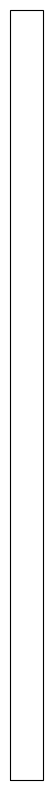

In [9]:
myFig = plt.figure(figsize=(10, 10))  # create a figure of size 10x10 (representing the page size in inches)

myCRS = ccrs.UTM(29)  # create a Universal Transverse Mercator reference system to transform our data.
# be sure to fill in XX above with the correct number for the UTM Zone that Northern Ireland is part of.

ax = plt.axes(projection=myCRS)  # finally, create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.

### Adding data to the map

Now that we've created a figure and axes, we can start adding data to the map. To start, we'll add the municipal borders. 

In order to add these to the map, we first have to create features that we can add to the axes using the `ShapelyFeature` class from `cartopy.feature`. The initialization method for this class takes a minimum of two arguments, an __iterable__ containing the geometries that we're using, and a CRS representation. 

To add the County borders, then, we would use `counties['geometry']`, the GeoSeries of the feature geometries in our Municipalities shapefile, and `myCRS`, the CRS object representing the UTM Zone for Northern Ireland:

In [10]:
# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = outline.total_bounds
ax.add_feature(outline_feature) # add the features we've created to the map.

The other arguments that we pass to `ShapelyFeature` tell `matplotlib` how to draw the features - in this case, with an edge color of black and a face color of gray. Once we've created the features, we add them to the axes using the `add_feature` method.

We'll also want to zoom the map into our area of interest using the boundary of the shapefile features (using `ax.set_extent`). In the example below, we're setting the extent with a 5 km buffer around each edge:

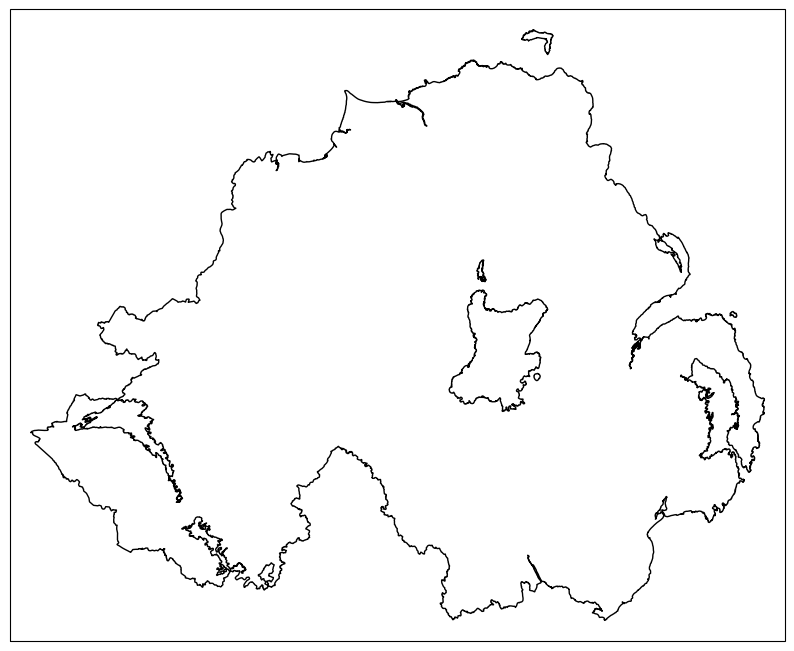

In [11]:
# using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=myCRS) # because total_bounds 
# gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

myFig ## re-draw the figure

This is fine, but a bit boring. For one thing, we might want to set different colors for the different municipalities, rather than having them all be the same color. To do this, we'll first have to count the number of __unique__ municipalities in our dataset, then select colors to represent each of them. 


<span style="color:blue;font-weight:bold;font-size:14pt">Question: Why might we do this, rather than just use the number of features in the dataset?</span>


Run the cell below to count the number of unique municipalities in the dataset, using the `unique` method on the __CountyName__ GeoSeries. 

Note that in addition to the standard indexing (i.e., `counties['CountyName']`), we are accessing __CountyName__ directly as an attribute of `counties` (i.e., `counties.CountyName`). 

Provided that the column name follows particular rules ([more on this here](http://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access)), there is no difference between these two methods - they give the same results.

In [31]:
# get the number of unique municipalities we have in the
int(towns['Status'].unique())
 # note how we're using {} and format here!


KeyError: 'Status'

Now that you've found the number of colors you need to choose, you can use the image below to make a list of the colors. There are other ways to select colors using matplotlib, including using RGB values, but that's for another day. If you're interested in learning more, you can check out the documentation [here](https://matplotlib.org/stable/api/colors_api.html).

![title](imgs/named_colors.png)
[source](https://matplotlib.org/stable/gallery/color/named_colors.html)

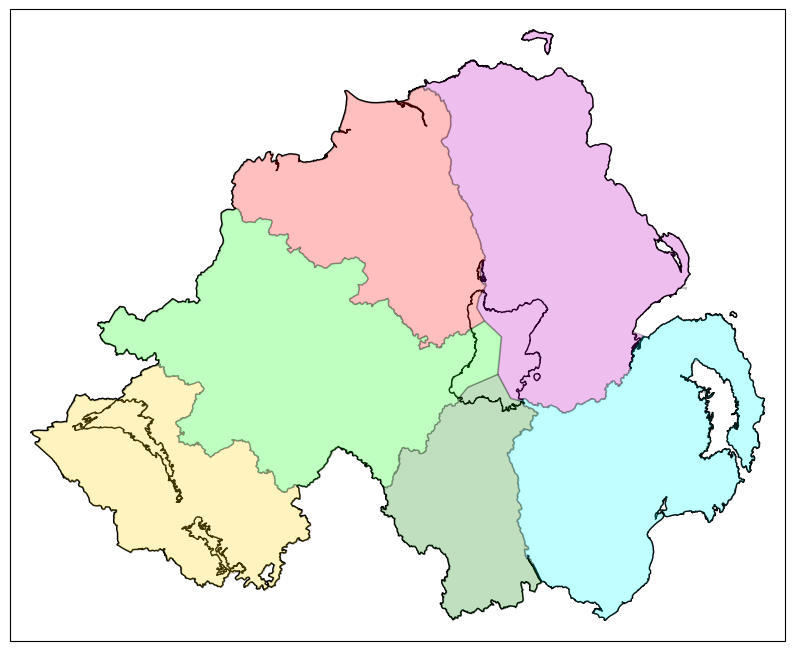

In [13]:
# pick colors for the individual county boundaries - make sure to add enough for each of the counties
# to add a color, enclose the name above (e.g., violet) with single (or double) quotes: 'violet'
# remember that each colors should be separated by a comma
county_colors = ['m','g','cyan','gold','red','lime']

# get a list of unique names for the county boundaries
county_names = list(counties.CountyName.unique())
county_names.sort() # sort the counties alphabetically by name

# next, add the municipal outlines to the map using the colors that we've picked.
# here, we're iterating over the unique values in the 'CountyName' field.
# we're also setting the edge color to be black, with a line width of 0.5 pt. 
# Feel free to experiment with different colors and line widths.
for ii, name in enumerate(county_names):
    feat = ShapelyFeature(counties.loc[counties['CountyName'] == name, 'geometry'], # first argument is the geometry
                          myCRS, # second argument is the CRS
                          edgecolor='k', # outline the feature in black
                          facecolor=county_colors[ii], # set the face color to the corresponding color from the list
                          linewidth=1, # set the outline width to be 1 pt
                          alpha=0.25) # set the alpha (transparency) to be 0.25 (out of 1)
    ax.add_feature(feat) # once we have created the feature, we have to add it to the map using ax.add_feature()

myFig # to show the updated figure

Now that we've done this for the municipal boundaries, we can also do this for the water datasets. Because we want the water bodies to be the same symbology, we add them with a single use of __ShapelyFeature__:

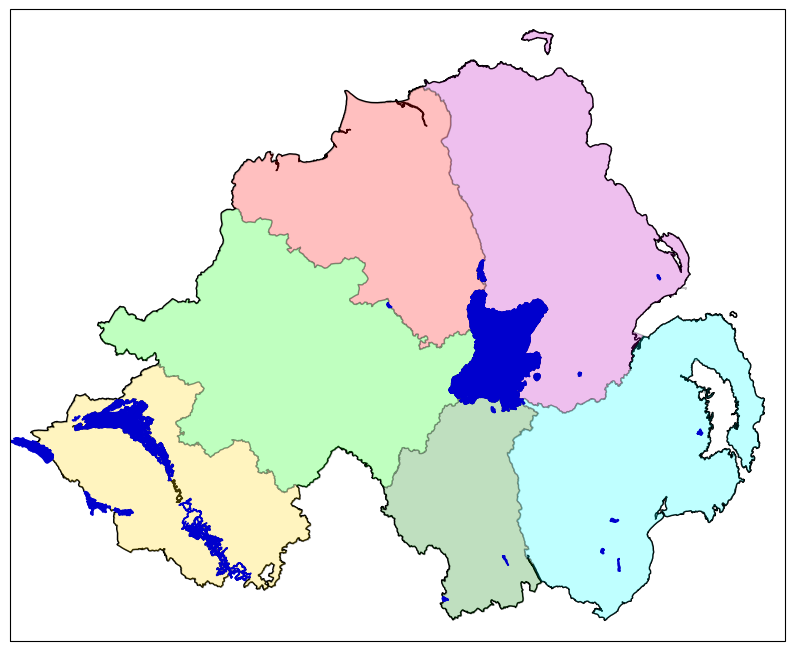

In [14]:
# here, we're setting the edge color to be the same as the face color. Feel free to change this around,
# and experiment with different line widths.
water_feat = ShapelyFeature(water['geometry'], # first argument is the geometry
                            myCRS, # second argument is the CRS
                            edgecolor='mediumblue', # set the edgecolor to be mediumblue
                            facecolor='mediumblue', # set the facecolor to be mediumblue
                            linewidth=1) # set the outline width to be 1 pt
ax.add_feature(water_feat) # add the collection of features to the map

myFig # to show the updated figure

We do the same thing with the rivers. However, because these are __Line__ objects, not **Polygon**s, we don't set the `facecolor` property:

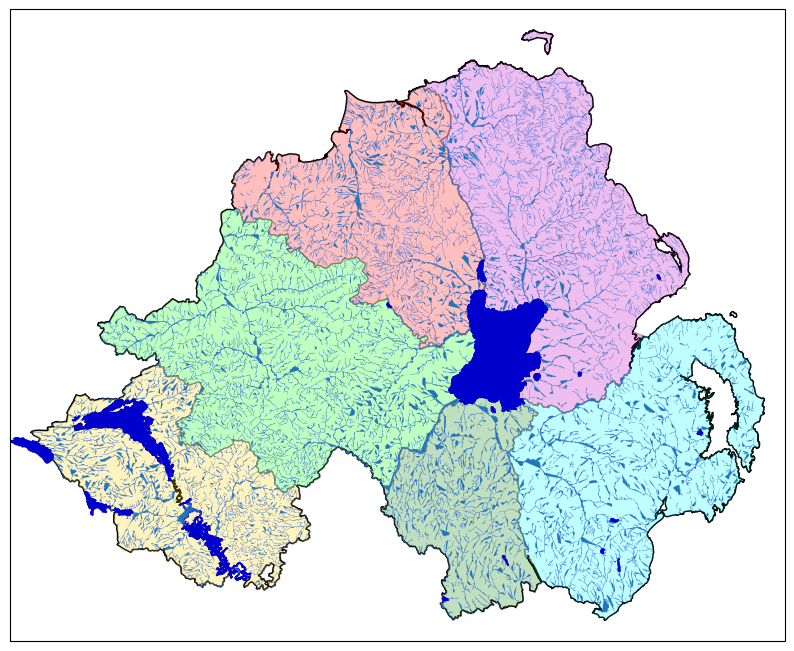

In [15]:
river_feat = ShapelyFeature(rivers['geometry'], # first argument is the geometry
                            myCRS, # second argument is the CRS
                            edgecolor='royalblue', # set the edgecolor to be royalblue
                            linewidth=0.2) # set the linewidth to be 0.2 pt
ax.add_feature(river_feat) # add the collection of features to the map

myFig # to show the updated figure

For __Point__ data, such as the town locations, we can use `ax.plot()` directly. 

The code below will add a gray (`color='0.5'`) square (`'s'`) marker of size 6 (`ms=6`) at each x, y location:

KeyError: 'Name'

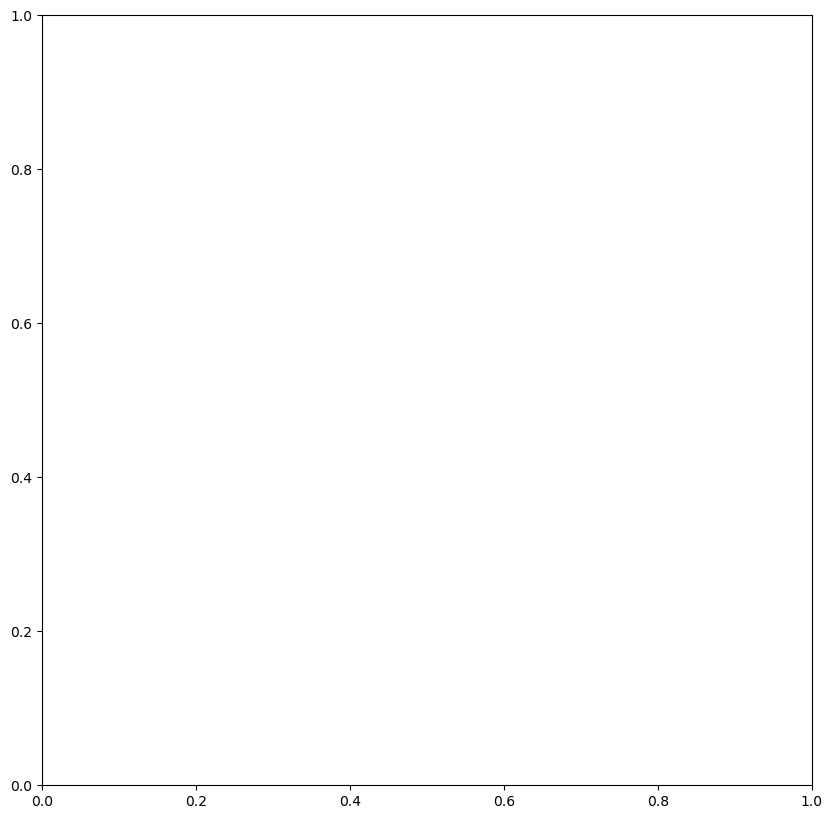

In [37]:
# ShapelyFeature creates a polygon, so for point data we can just use ax.plot()
fig,ax=plt.subplots(figsize=(10,10))
towns.plot(column='Name',
            categorical=True,
          legend=True,
          ax=ax)
leg=ax.get_legend()
leg.set_bbox_to_anchor((0.5,0.5))
ax.set_axis_off()
plt.show()
myFig # to show the updated figure

### Adding labels and legends

Now that we have different colors for each of the county boundaries and we've displayed lakes, rivers, and towns, it might be good to have a legend to keep everything straight.

To do this, we get handles for each of the county boundaries, using the colors we defined earlier. Here, we're using our helper function `generate_handles`, which returns a list of `matplotlib` handles (i.e., the symbol that `matplotlib` uses to display the objects in the figure), given a list of labels and colors. 

We then do the same for the water bodies and rivers:

In [17]:
# generate a list of handles for the county datasets
# first, we add the list of names, then the list of colors, and finally we set the transparency
# (since we set it in the map)
county_handles = generate_handles(counties.CountyName.unique(), county_colors, alpha=0.25)

# note: if you change the color you use to display lakes, you'll want to change it here, too
water_handle = generate_handles(['Lakes'], ['mediumblue'])

# note: if you change the color you use to display rivers, you'll want to change it here, too
river_handle = [mlines.Line2D([], [], color='royalblue')]

Note that the names in our county dataset are all uppercase - that's not necessarily how we want to display them on the map. To change this, we can use a string method called __title()__, which will capitalize the first letter of each word in a string. We also have to do this for each of the items in our list of names. We _could_ write this as a __for__ loop, like this:

```python
nice_names = []  # initalize an empty list
for name in county_names:
    nice_names.append(name.title())

```

But, python offers another, cleaner option, called a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions). A list comprehension allows us to generate a new list from an existing iterable. To write the same __for__ loop above as a list comprehension takes one line:

In [18]:
# update county_names to take it out of uppercase text
nice_names = [name.title() for name in county_names]

That's it. This creates a new list by iterating over each of the items in county_names, applying a method, __str.title()__, to each item. We'll work more with list comprehensions throughout the module, as they provide a way to simplify some pretty complicated loops.

We can pass each of our lists of handles and labels to `plt.legend`, to generate a legend for the municipal boundaries data. Feel free to experiment with the placement (by changing __loc__ and/or __bbox_to_anchor__), or the font size, the title font size, and so on.

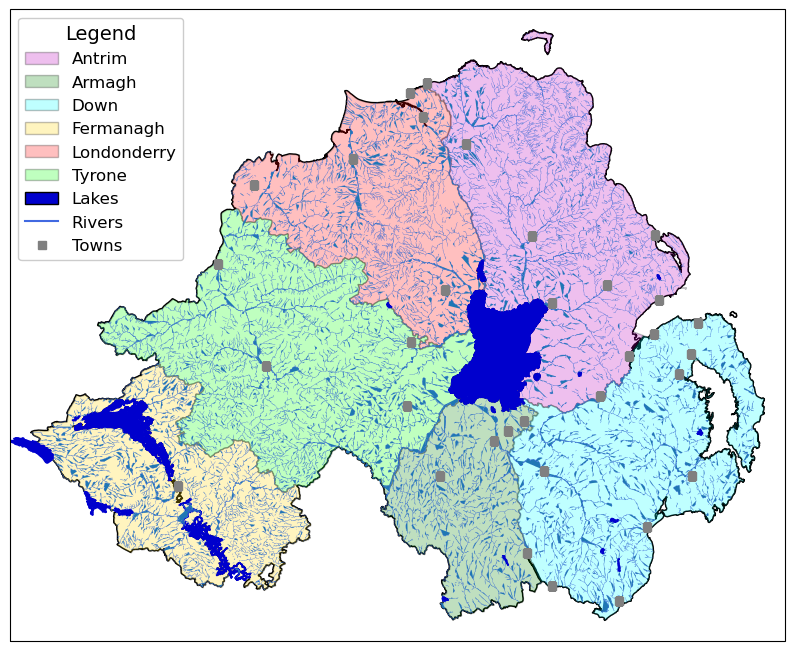

In [19]:
# ax.legend() takes a list of handles and a list of labels corresponding to the objects 
# you want to add to the legend
handles = county_handles + water_handle + river_handle + town_handle # use '+' to concatenate (combine) lists
labels = nice_names + ['Lakes', 'Rivers', 'Towns']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=14, 
                 fontsize=12, loc='upper left', frameon=True, framealpha=1)

myFig # to show the updated figure

Now that we have a legend, let's go ahead and add grid lines to our plot. I've chosen some default gridlines, but you can feel free to change this. 

What happens if you delete the first and/or last value from xlocs and ylocs? Try it and see!

Can you change the labels to show only on the bottom and left side of the map? To see, try looking at this [example](https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html), or at the [documentation](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.gridliner.Gridliner.html#cartopy.mpl.gridliner.Gridliner).

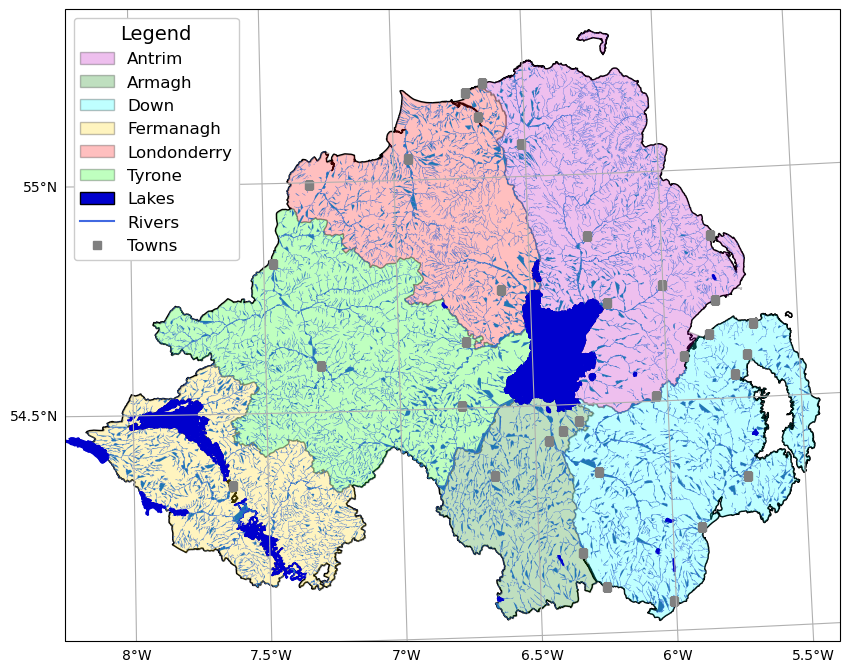

In [20]:
gridlines = ax.gridlines(draw_labels=True, # draw  labels for the grid lines
                         xlocs=[-8,-7.5, -7, -6.5, -6, -5.5], # add longitude lines at 0.5 deg intervals
                         ylocs=[54, 54.5, 55,55.5]) # add latitude lines at 0.5 deg intervals
gridlines.right_labels = False # turn off the left-side labels
gridlines.top_labels = False # turn off the bottom labels

myFig # to show the updated figure

Excellent. Now, let's add text labels for each of our individual towns. For each of the points representing our towns/cities, we can place a text label. Look over the cell below, and make sure you understand what each line is doing. If you're not sure you understand, you can post your questions on Blackboard.

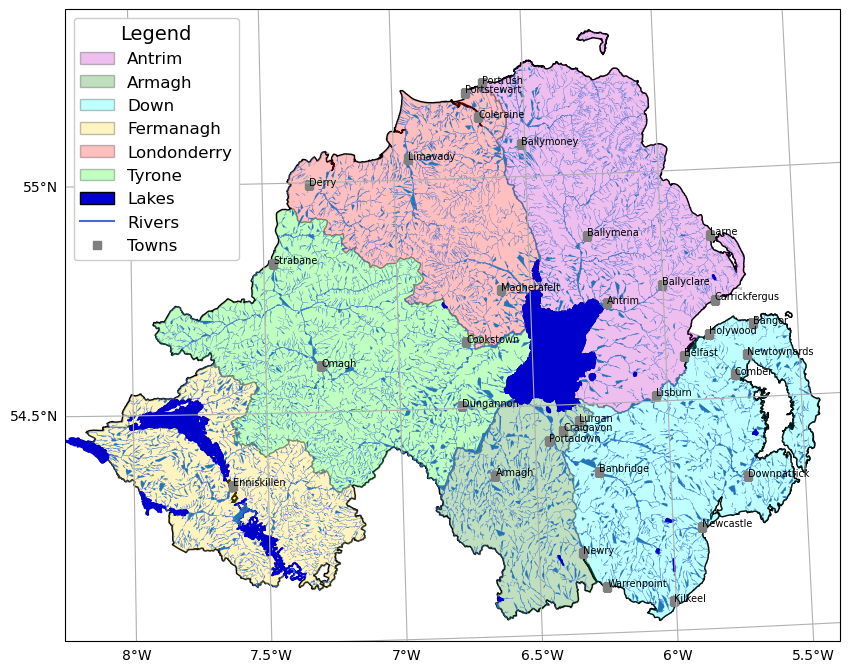

In [21]:
for ind, row in towns.iterrows(): # towns.iterrows() returns the index and row
    x, y = row.geometry.x, row.geometry.y # get the x,y location for each town
    ax.text(x, y, row['TOWN_NAME'].title(), fontsize=7, transform=myCRS) # use plt.text to place a label at x,y

myFig # to show the updated figure    

Last but not least, let's add a scale bar to the plot. The scale_bar function we've defined above will produce a scale bar with divisions at 10 and 20 km, with a location in the upper right corner as default. Try to experiment with this a bit - can you design a scale bar with divisions at 1, 5, and 10 km? It's not as straightforward as it is in ArcGIS, but it might provide an interesting challenge if you're interested in developing your programming skills a bit.

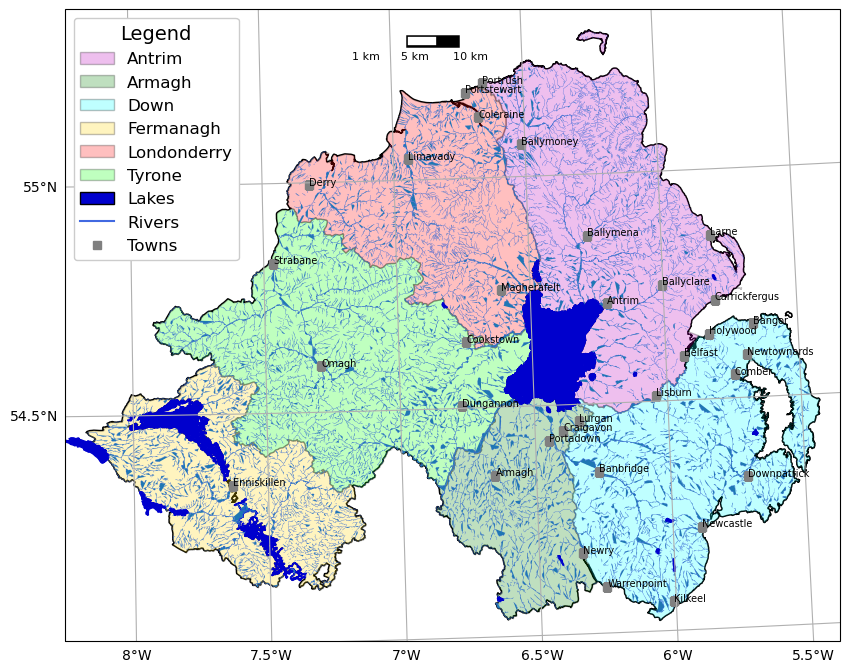

In [22]:
scale_bar(ax)

myFig # to show the updated figure

Finally, we'll save our figure. The command written below will save the figure to the current folder, in a file called `map.png`, with no border around the outside of the map, and with a resolution of 300 dots per inch. As always, feel free to change these parameters.

In [23]:
myFig.savefig('map.png', bbox_inches='tight', dpi=300)

## Next steps

In this directory, you should also have a python script, __practical2_script.py__, which will create the same map that we've made here (though perhaps with different colors).

Note that the __towns__ dataset has an attribute, __STATUS__, that describes whether the feature represents a __Town__ (e.g., Coleraine), or a __City__ (e.g., Belfast). As a further exercise, see if you can modify the script to plot all of the __Towns__ with one marker (e.g., the gray square used above), and plot all of the __Cities__ plot with a different marker, then add these to the legend. For more information on the available markers and colors for matplotlib, see the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html).